<a href="https://colab.research.google.com/github/battistabiggio/ai4dev/blob/main/notebooks/gaussian-classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Gaussian Classifier

We implement here a Gaussian classifier. It's a Bayesian (generative) classifier that models the likelihood of each class with a Gaussian distribution. Accordingly, it classifies a sample $x$ by assigning it to the class $y_k^\star$ exhibiting the maximum a-posteriori probability:

$y_k^\star = \arg\max_{y_k} p(y_k | x ) = \frac{p(x|y_k) p_k}{p(x)},$

where $p_k$ is the prior probability of class $y_k$, and the likelihood $p(x | y_k)$ is estimated as:

$$p(x | y_k) = \mathrm{g}(x ; \mu_k, \Sigma_k)=\frac{1}{\sqrt{(2 \pi)^{d} \operatorname{det} \Sigma_k}} \exp \left(-\frac{1}{2}(x-\mu_k)^{T} \Sigma_k^{-1}(x-\mu_k)\right).$$

Recall that the evidence $p(x)$ can be computed by marginalizing over the labels, as $p(x) = \sum_k p(x | y_k) p_k$.  


In the class below,
- ```fit(x,y)``` estimates the classifier's hyperparameters $\mu_k, \Sigma_k, p_k$ for each class, from the training data ```x,y``` given as input;
- `decision_function(x)` returns a matrix (`scores`) with ```shape=(n_samples, n_classes)```, where each element represents the probability that the given point belongs to the corresponding class;
- and ```predict(x)``` returns the predicted labels (by taking the argmax for each row from `scores`).

In [1]:
import numpy as np
from scipy.stats import multivariate_normal as mvn


class CClassifierGaussian:
    """
    Class implementing a Gaussian classifier
    """

    def __init__(self, posterior=True):
        self._centroids = None
        self._covariances = None
        self._priors = None
        # if True, return posterior probabilities; otherwise returns joint probs
        self._posterior = posterior
        return


    @property
    def posterior(self):
        return self._posterior

    @posterior.setter
    def posterior(self, value):
        self._posterior = bool(value)

    @property
    def centroids(self):
        return self._centroids

    @centroids.setter
    def centroids(self, centroids):
        """Set centroids (if not estimated from training data)."""
        self._centroids = np.array(centroids)

    @property
    def covariances(self):
        return self._covariances

    @covariances.setter
    def covariances(self, covariances):
        """Set covariances (if not estimated from training data)."""
        self._covariances = np.array(covariances)

    @property
    def priors(self):
        return self._priors

    @priors.setter
    def priors(self, priors):
        """Set priors (if not estimated from training data)."""
        self._priors = np.array(priors)

    def fit(self, x, y):
        """Estimate priors, centroids and covariances with
        maximum likelihood estimates from the training data x,y.
        """
        n_classes = np.unique(y).size
        n_features = x.shape[1]

        self._priors = np.zeros(shape=(n_classes,))
        self._centroids = np.zeros(shape=(n_classes, n_features))
        self._covariances = np.zeros(shape=(n_classes, n_features, n_features))

        for k in range(n_classes):
            self._centroids[k, :] = x[y == k, :].mean(axis=0)
            self._priors[k] = (y == k).mean()
            self._covariances[k, :, :] = np.cov(x[y==k, :].T)

        self._priors /= self._priors.sum()  # ensure priors sum up to 1
        return self

    def decision_function(self, x):
        """Return posterior or joint probability estimates for each class,
        depending on whether posterior=True or False.
        """
        n_samples = x.shape[0]
        n_classes = self._centroids.shape[0]
        scores = np.zeros(shape=(n_samples, n_classes))
        for k in range(n_classes):
            likelihood_k = mvn.pdf(
                x, mean=self._centroids[k, :], cov=self._covariances[k, :, :])
            scores[:, k] = self._priors[k] * likelihood_k  # joint probability

        if self.posterior:
            # if posterior probs are required, divide joint probs by evidence
            evidence = scores.sum(axis=1)
            for k in range(n_classes):
                # normalize per row to estimate posterior
                scores[:, k] /= evidence
        return scores

    def predict(self, x):
        """Return predicted labels."""
        scores = self.decision_function(x)
        y_pred = np.argmax(scores, axis=1)
        return y_pred



Let's now import some utility functions (whose implementation is discussed in other notebooks):
- ```make_gaussian_dataset``` to generate a Gaussian dataset;
- ```plot_dataset``` to scatter the data points on a bi-dimensional feature space;
- ```plot_decision_regions``` to display the decision regions and boundaries of a classifier on a bi-dimensional feature space.

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


def make_gaussian_dataset(n, mu, cov):
    """
    Creates a k-class d-dimensional Gaussian dataset.
    :param n: vector containing the number of samples for each class
    :param mu: matrix containing the mean vector for each class
    :return: x,y, the gaussian dataset
    """

    n = np.array(n)  # convert to np.array if list is passed as input
    mu = np.array(mu)
    cov = np.array(cov)

    n_classes = mu.shape[0]  # number of classes
    n_features = mu.shape[1]  # number of features
    n_samples = n.sum()  # total number of samples

    x = np.zeros(shape=(n_samples, n_features))
    y = np.zeros(shape=(n_samples,))

    start_index = 0
    for k in range(n_classes):
        x_tmp = mvn.rvs(mean=mu[k, :], cov=cov[k, :, :], size=n[k])
        x[start_index:start_index + n[k], :] = x_tmp
        y[start_index:start_index + n[k]] = k
        start_index += n[k]

    return x, y


def plot_dataset(x, y, feat_1=0, feat_2=1):
    n_classes = len(np.unique(y))
    colors = ['r', 'b', 'g', 'k', 'c', 'm', 'y']

    for y0 in range(n_classes):
        x0 = x[y == y0, feat_1]  # y0 is the selected class within the loop
        x1 = x[y == y0, feat_2]
        plt.scatter(x0, x1, c=colors[y0], label='class ' + str(y0))
    plt.legend()
    plt.xlabel('feature x' + str(feat_1))
    plt.ylabel('feature x' + str(feat_2))

    return


def plot_decision_regions(x, y, classifier, resolution=0.02):
    # setup marker generator and color map
    colors = ('red', 'blue', 'lightgreen', 'black', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    x2_min, x2_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    return


## Exercise 1

We can finally generate some data points and test our classifier!

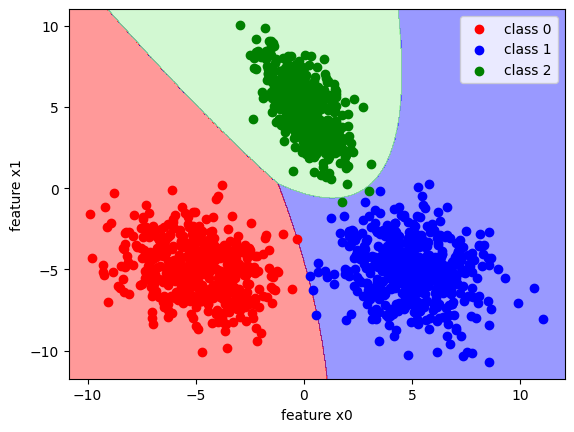

Estimated priors:  [0.33333333 0.33333333 0.33333333]
Estimated centroids (with MLE):  [[-4.95601026 -4.94883265]
 [ 5.05845886 -5.09354173]
 [ 0.02395398  4.96218652]]
Estimated covariances (with MLE):  [[[ 3.12627194 -0.75968643]
  [-0.75968643  2.83905263]]

 [[ 2.93202636 -0.57031964]
  [-0.57031964  3.39651301]]

 [[ 0.98847044 -1.06947404]
  [-1.06947404  3.0640781 ]]]
Test error (%):  0.26666666666666666


In [3]:
n_samples = [500, 500, 500]
centroids = [[-5, -5],
             [+5, -5],
             [0, +5]]
cov=[[[3, -1],
      [-1, 3]],
     [[3, -0.5],
      [-0.5, 3]],
     [[1, -1],
      [-1, 3]]]

# generate data
x_tr, y_tr = make_gaussian_dataset(n_samples, centroids, cov=cov)
x_ts, y_ts = make_gaussian_dataset(n_samples, centroids, cov=cov)

clf = CClassifierGaussian()
clf.fit(x_tr, y_tr)
plot_decision_regions(x_tr, y_tr, classifier=clf)
plot_dataset(x_tr, y_tr)
plt.show()

scores = clf.decision_function(x_ts)
y_pred = clf.predict(x_ts)

print('Estimated priors: ', clf.priors)
print('Estimated centroids (with MLE): ', clf.centroids)
print('Estimated covariances (with MLE): ', clf.covariances)

print('Test error (%): ', (y_pred != y_ts).mean()*100)



## Exercise 2

We now solve a different task, but using the true parameter values $p_k, \mu_k, \Sigma_k$ for each class rather than estimating them with `fit`.

In particular, we consider this data distribution (the same considered in Exercise 2 from Chapter 4):

$$\mathbf{\mu}_{0}=\left[\begin{array}{l}
0 \\
0
\end{array}\right], \mathbf{\mu}_{1}=\left[\begin{array}{l}
2 \\
2
\end{array}\right], \mathbf{\mu}_{2}=\left[\begin{array}{l}
-2 \\
-2
\end{array}\right],$$

$$\Sigma_{0}=\Sigma_{1}=\Sigma_{2}=\left[\begin{array}{cc}
4 & -3 \\
-3 & 4
\end{array}\right],$$

and priors $p_0=p_1=1/4$ and $p_2=1/2$.

Our goal is to plot the decision regions for the optimal Bayesian classifier in this case, as well as the joint and posterior probabilities for each class.

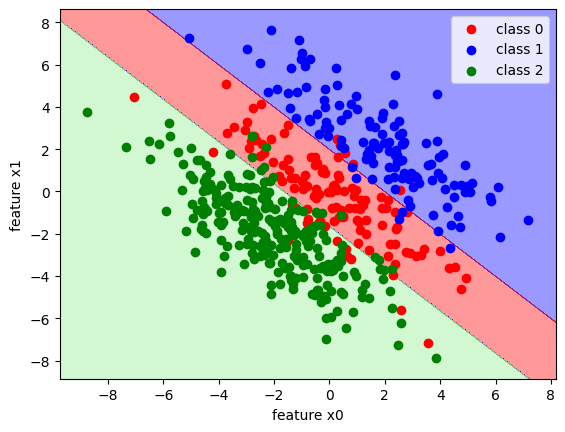

Test error (%):  8.84


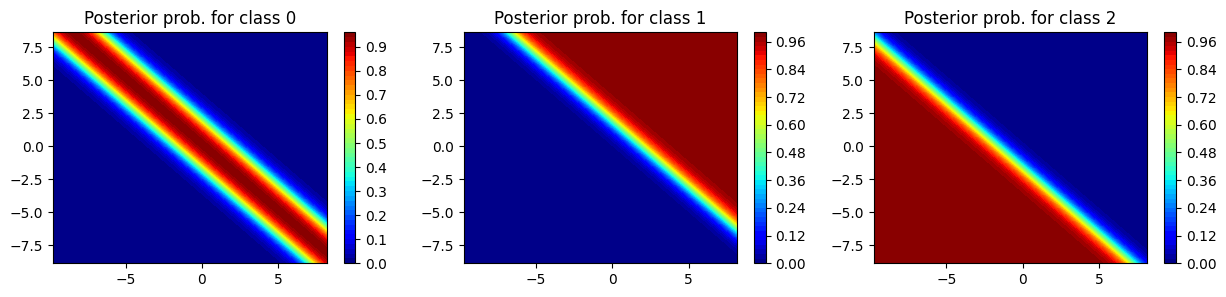

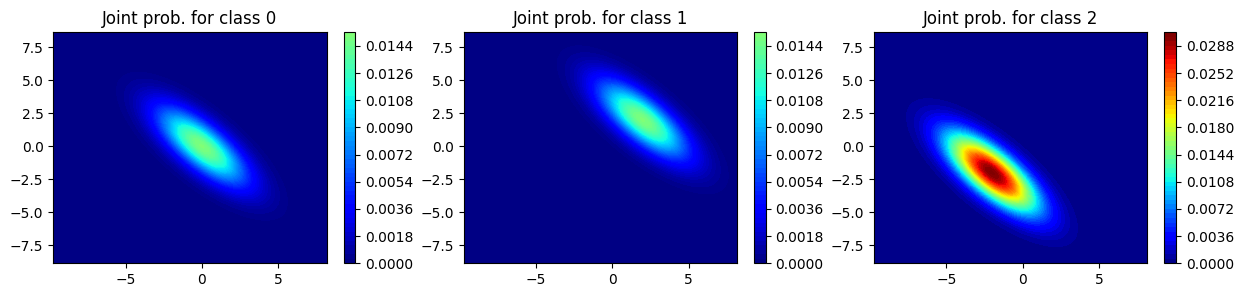

In [4]:
def plot_decision_function(x, y, classifier, k, resolution=0.02):
    """Plot classifier output on class k (e.g., joint or posterior prob.)."""
    x1_min, x1_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    x2_min, x2_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    scores = classifier.decision_function(
        np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = scores[:, k]  # select the output of interest (for class k)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, cmap='jet', levels=50)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    return

priors = np.array([1/4, 1/4, 1/2])
centroids = [[0, 0],
             [2, 2],
             [-2, -2]]
cov=[[[4, -3], [-3, 4]],
     [[4, -3], [-3, 4]],
     [[4, -3], [-3, 4]]]

# generate some points from this distribution
n_samples = np.array(500 * priors, dtype=int)
x_tr, y_tr = make_gaussian_dataset(n_samples, centroids, cov=cov)
x_ts, y_ts = make_gaussian_dataset(10*n_samples, centroids, cov=cov)

clf = CClassifierGaussian()
# we do not estimate the parameters here, but use the true ones
# clf.fit(x_tr, y_tr)
clf._priors = np.array(priors)
clf._centroids = np.array(centroids)
clf._covariances = np.array(cov)
plot_decision_regions(x_tr, y_tr, classifier=clf)
plot_dataset(x_tr, y_tr)
plt.show()

scores = clf.decision_function(x_ts)
y_pred = clf.predict(x_ts)
print('Test error (%): ', (y_pred != y_ts).mean()*100)

plt.figure(figsize=(15,3))
for k in range(n_samples.size):
    plt.subplot(1, 3, k+1)
    plot_decision_function(x_tr, y_tr, classifier=clf, k=k)
    plt.title("Posterior prob. for class " + str(k))
    plt.colorbar()
plt.show()

clf.posterior = False  # this will return joint probs rather than posteriors
plt.figure(figsize=(15,3))
for k in range(n_samples.size):
    plt.subplot(1, 3, k+1)
    plot_decision_function(x_tr, y_tr, classifier=clf, k=k)
    plt.title("Joint prob. for class " + str(k))
    plt.clim(0, 0.03)
    plt.colorbar()
plt.show()


As one may appreciate, the joint probability of class 2 has a higher peak since its prior is higher.

But let's look at the evidence $p(x)$ in 3D to get a clearer impression...

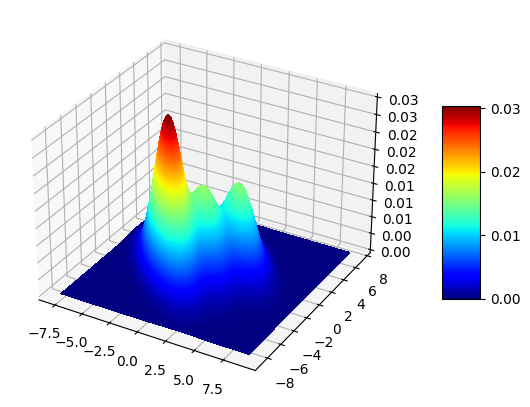

In [8]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(projection='3d')

x, y = make_gaussian_dataset(n_samples, centroids, cov=cov)
resolution = 0.02

# Make data.
x1_min, x1_max = x[:, 0].min() - 1, x[:, 0].max() + 1
x2_min, x2_max = x[:, 1].min() - 1, x[:, 1].max() + 1
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                        np.arange(x2_min, x2_max, resolution))
scores = clf.decision_function(
    np.array([xx1.ravel(), xx2.ravel()]).T)
Z = scores.sum(axis=1)  # evidence
Z = Z.reshape(xx1.shape)

# Plot the surface.
surf = ax.plot_surface(xx1, xx2, Z, cmap='jet', rstride=1, cstride=1,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0, 0.03)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()